# Credible Concept Model (CCM) tutorial: Extend credible model to uninterpretable raw features

By the end of the tutorial, one should be able to

1. understand the motivation of CCM
2. understand the CCM algorithm
3. able to train an CCM model

In [23]:
import numpy as np
import types
import copy
import shap
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# A motivating example

Despite the fact that model interpretation suffers from faithfulness and fragility issues (and also people's overtrust of the interpretation), it is still useful to enforce prior knowledge. Feature attribution tools often assume that features are interpretable. This makes them less applicable when raw features are complicated (say in the image or audio domain). Thus, a lot of recent research effort have been poured in to explanation with high level concepts. Among them is this idea of concept bottleneck network (CBM). In this work, we expose the flaw of CBM and suggest a simple fix.

This examples shows why missing concept is a nastier problem than one would think.

$Z \sim U(\{0, 1\})^d$ are $d$ latent concepts

$X = project(Z)$ is a random linear projection of concepts presented to the human (the following just used identity for simplicity)

$X \rightarrow C \rightarrow X$ where $C \in \mathbb{R}^{d-1}$ is concept detectors

$Y = and(Z)$ where $\theta$ is the true coefficient.

This setup will fail raw feature attribution (because $X$ distribute concepts across dimensions), concept discovery (when the function is a "and" concept), jointly trained concept (because $C$ has 1 less dimension off $Z$).

In [2]:
n = 10000
d = 3 # true number of concepts needed for classification
c = 1 # number concepts to learn for EBM
bs = 100
n_epochs = 50

def gen_data(n, d):
    Z = np.random.choice([0, 1], (n, d))
    X = Z
    # and of the arguments
    Y = np.ones(n)
    for i in range(d):
        Y = np.logical_and(Y, Z[:, i])

    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(Z).float()

def get_output(net, loader_x):
    o = []
    for x, in loader_x:
        o.extend(net(x).detach().numpy())
    return np.vstack(o) # (n, c)

X, Y, Z = gen_data(n, d)
X_te, Y_te, Z_te = gen_data(n, d)
print(f'Percentage of ones {(1-0.5**d)*100:.2f}%')

Percentage of ones 87.50%


**Note that the above value ($1-1/2^d$) is also the theoretical limit the accuracy of EBM** because

\begin{align}
P(\hat{y} = y) &= P(Z_1=Z_2=\cdots=Z_c=1) P (\hat{y} = y | Z_1=Z_2=\cdots=Z_c=1) + P(\overline{Z_1=Z_2=\cdots=Z_c=1}) P(\hat{y} = y | \overline{Z_1=Z_2=\cdots=Z_c=1})\\
&= 1 / 2^c \cdot (1 - 1 / 2^{d-c}) + (1 - 1 / 2^c) \cdot 1\\
&= 1 - 1 / 2^d
\end{align}

In [3]:
class MLP(nn.Module):

    def __init__(self, neuron_sizes, activation=nn.ReLU, bias=True): 
        super(MLP, self).__init__()
        self.neuron_sizes = neuron_sizes
        
        layers = []
        for s0, s1 in zip(neuron_sizes[:-1], neuron_sizes[1:]):
            layers.extend([
                nn.Linear(s0, s1, bias=bias),
                activation()
            ])
        
        self.classifier = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        x = x.view(-1, self.neuron_sizes[0])
        return self.classifier(x)

class LambdaNet(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        import types
        assert type(lambd) is types.LambdaType
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class AdditionNet(nn.Module):
    '''
    output net_a(x) + net_b(x)
    '''

    def __init__(self, net_a, net_b): 
        super(AdditionNet, self).__init__()
        self.net_a = net_a
        self.net_b = net_b
        
    def forward(self, x):
        return self.net_a(x) + self.net_b(x)

def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

def plot_log(log, key="loss"):
    '''log is train log [{epoch: xxx, loss: xxx}]'''
    x = [item['epoch'] for item in log]
    y = [item[key] for item in log]
    plt.semilogy(x, y)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel(key, fontsize=15)
    plt.plot()
    
def train_step_standard(net, loader, opt, criterion, device='cpu'):
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        o = net(x)
        l = criterion(o, y).mean()
        l.backward()
        opt.step()
        losses.append(l.detach().item())
    return losses
    
def train(net, loader, opt, train_step=train_step_standard, 
          criterion=F.cross_entropy, n_epochs=10, report_every=1,
          device="cpu"):
    net.train()
    train_log, losses = [], []

    for i in range(n_epochs):
        
        _losses = train_step(net, loader, opt, criterion, device=device)
        losses.extend(_losses)
        
        train_report = {"loss": np.mean(losses[-len(loader):])}
        
        if (i+1) % report_every == 0: # report loss
            print('epoch {:>3}: '.format(i) + ' '.join('{} {:.3e}'.format(
                      name, val
                  ) for name, val in train_report.items()))

        train_report.update({'epoch': i})
        train_log.append(train_report)

    return train_log    
    
def test(net, loader, criterion):
    net.eval()
    losses = []
    total = 0
    for x, y in loader:
        o = net(x)
        l = criterion(o, y).mean()
        bs = o.shape[0]
        total += bs        
        losses.append(l.detach().item() * bs)
    net.train()
    return sum(losses) / total

# report accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xyz = DataLoader(TensorDataset(X, Y, Z), batch_size=bs, shuffle=True) # joint concept and regular dataset

loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=True) # regular dataset
loader_xyz_te = DataLoader(TensorDataset(X_te, Y_te, Z_te), batch_size=bs, shuffle=True) # joint concept and regular dataset

## standard model

epoch   4: loss 2.865e-01
epoch   9: loss 1.509e-01
epoch  14: loss 6.454e-02
epoch  19: loss 2.821e-02
epoch  24: loss 1.429e-02
epoch  29: loss 8.049e-03
epoch  34: loss 4.887e-03
epoch  39: loss 3.126e-03
epoch  44: loss 2.077e-03
epoch  49: loss 1.418e-03


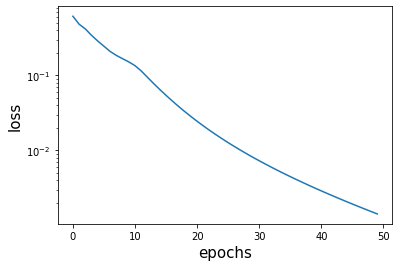

In [4]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, d * 2, 2])

    # train
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

standard_net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [5]:
print('task acc after training: {:.1f}%'.format(test(standard_net, loader_xy_te, acc_criterion) * 100))

task acc after training: 100.0%


## joint EBM

number of concepts to learn: 1
true number of concepts: 3
epoch   4: loss 8.863e-03
epoch   9: loss 3.714e-03
epoch  14: loss 2.278e-03
epoch  19: loss 1.472e-03
epoch  24: loss 9.852e-04
epoch  29: loss 6.487e-04
epoch  34: loss 4.003e-04
epoch  39: loss 2.389e-04
epoch  44: loss 1.588e-04
epoch  49: loss 1.138e-04


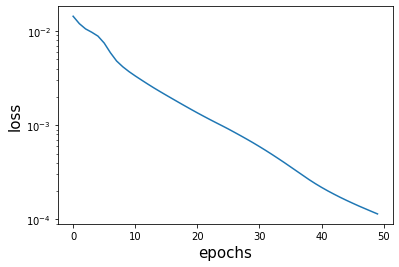

In [6]:
class EBM(nn.Module):
    '''
    net_c is concept net, net_y is the task net
    it output net_y(net_c(x))
    '''

    def __init__(self, net_c, net_y): 
        super(EBM, self).__init__()
        self.net_c = net_c
        self.net_y = net_y
        
        self.classifier = nn.Sequential(net_c, net_y)
        
    def forward(self, x):
        return self.classifier(x)

def train_step_xyz(net, loader, opt, criterion, device='cpu'):
    '''training step for EBM jont model'''
    assert type(net) == EBM, f"must use EBM model; currently {type(net)}"
    losses = []
    for x, y, z in loader:
        x, y, z = x.to(device), y.to(device), z.to(device)
        opt.zero_grad()
        o_z = net.net_c(x)
        o_y = net.net_y(o_z)
        l = criterion(o_y, y, o_z, z).mean()
        l.backward()
        opt.step()
        losses.append(l.detach().item())
    return losses

def joint_EBM(d, c, loader_xyz, n_epochs=10, report_every=1, plot=True):
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task jointly trained
    net_c = MLP([d, d * 2, c])
    net_y = MLP([c, d * 2, 2])
    net = EBM(net_c, net_y)
    
    # train
    def criterion(o_y, y, o_z, z):
        y_loss = F.cross_entropy(o_y, y).sum()
        z_loss = F.binary_cross_entropy(torch.sigmoid(o_z), z[:, :c]).sum()
        return (y_loss + z_loss) / len(y)
    
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xyz, opt, train_step=train_step_xyz, 
                criterion=criterion, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    
    return net

ebm_joint = joint_EBM(d, c, loader_xyz, n_epochs=n_epochs, report_every=n_epochs//10)

In [7]:
# todo: clean: now assumes net_c output binary prediction
def test_concept(net, concept_idx, loader):
    '''net output many logit for concepts, concept_idx is the concept index'''
    net.eval()
    losses = []
    total = 0
    for x, y in loader:
        o = net(x) # (bs, c)
        o2 = torch.sigmoid(o[:, concept_idx]) > 0.5
        l = (o2 == y).float().mean()
        bs = o.shape[0]
        total += bs        
        losses.append(l.detach().item() * bs)
    net.train()
    return sum(losses) / total

def print_concept_acc(net_c, c, X_te, Z_te):
    for i in range(c):
        print('concept {} acc after training: {:.1f}%'.format(i, test_concept(net_c,
                                                                              i,
                                                                              DataLoader(TensorDataset(X_te, Z_te[:, i]), batch_size=bs)) * 100))

print('task acc after training: {:.1f}%'.format(test(ebm_joint, loader_xy_te, acc_criterion ) * 100))
print_concept_acc(ebm_joint.net_c, c, X_te, Z_te)

task acc after training: 100.0%
concept 0 acc after training: 100.0%


**Note Jointly trained EBM has accuracy above the thoretical limit of ($1 - 2^d$) without sacrificing concept accuracy. This is why it is wrong!**

## independent EBM

number of concepts to learn: 1
true number of concepts: 3
training concepts ...
epoch   4: loss 3.581e-01
epoch   9: loss 7.912e-02
epoch  14: loss 2.580e-02
epoch  19: loss 1.166e-02
epoch  24: loss 6.286e-03
epoch  29: loss 3.749e-03
epoch  34: loss 2.385e-03
epoch  39: loss 1.584e-03
epoch  44: loss 1.085e-03
epoch  49: loss 7.595e-04
training tasks ...
epoch   4: loss 3.381e-01
epoch   9: loss 2.959e-01
epoch  14: loss 2.868e-01
epoch  19: loss 2.842e-01
epoch  24: loss 2.832e-01
epoch  29: loss 2.826e-01
epoch  34: loss 2.823e-01
epoch  39: loss 2.821e-01
epoch  44: loss 2.819e-01
epoch  49: loss 2.818e-01


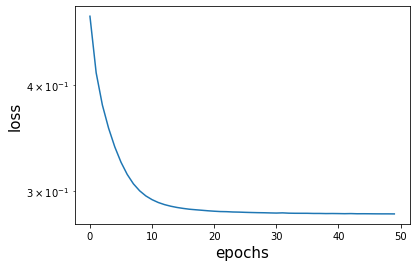

In [8]:
def ind_EBM(d, c, X, Y, Z, n_epochs=10, report_every=1, plot=True):
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task independently trained
    net_c = nn.Sequential(MLP([d, d * 2, c]), nn.Sigmoid())
    net_y = MLP([c, d * 2, 2])
    net = EBM(net_c, net_y)
    
    # train
    print('training concepts ...')
    opt_c = optim.Adam(net_c.parameters())
    train(net_c, 
          DataLoader(TensorDataset(X, Z[:, :c]), batch_size=bs, shuffle=True), 
          opt_c, criterion=nn.BCELoss(), n_epochs=n_epochs, report_every=report_every)

    print('training tasks ...')
    opt_y = optim.Adam(net_y.parameters())
    log = train(net_y, 
                DataLoader(TensorDataset(Z[:, :c], Y), batch_size=bs, shuffle=True), 
                opt_y, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)

    return net

ebm_ind = ind_EBM(d, c, X, Y, Z, n_epochs=n_epochs, report_every=n_epochs//10)

In [9]:
print('task acc after training: {:.2f}%'.format(test(ebm_ind, loader_xy_te, acc_criterion ) * 100)) # the optimum is 1/16 + 3/4; the strategy is to randomize if the first concept is 1, otherwise output 0
print_concept_acc(ebm_ind.net_c[0], c, X_te, Z_te) # net_c[0] because it is the logit part

task acc after training: 87.32%
concept 0 acc after training: 100.0%


## Concept completeness

Since concept can overload in joint EBM, concept completeness measure would only help if we can understand what concept it is using, which defeats the purpose of using high level feature.

In [10]:
# generate all possible input
explain_X = []
for i in range(2**d):
    item = np.zeros(d)
    idx = 0
    while i != 0:
        idx += 1
        item[-idx] = i % 2
        i = i // 2
    explain_X.append(item)
explain_X = torch.from_numpy(np.array(explain_X)).float()
shap_x = pd.DataFrame(explain_X.numpy(), columns=[f'X{i}' for i in range(d)])
shap_x

,X0,X1,X2
0,0.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,1.0
4,1.0,0.0,0.0
5,1.0,0.0,1.0
6,1.0,1.0,0.0
7,1.0,1.0,1.0


   X0  X1  X2  logit Z0
3   0   1   1     -9.67
2   0   1   0     -7.76
1   0   0   1     -6.43
0   0   0   0     -4.52
7   1   1   1      3.73
5   1   0   1      8.67
6   1   1   0      8.71
4   1   0   0     13.65
Explaining logit Z0


  0%|          | 0/8 [00:00<?, ?it/s]

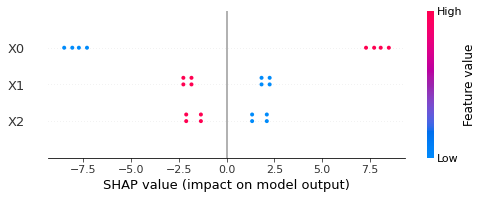

In [174]:
def shap_net_x(net, shap_x, bs, shap_idx=None, decimal=2, column_name="hat Y"):
    '''
    explain net on input level
    '''
    prediction = get_output(net, 
                            DataLoader(TensorDataset(torch.from_numpy(np.array(shap_x))), 
                                       batch_size=bs, shuffle=False))
    d_o = prediction.shape[1]

    print(
        pd.concat((shap_x.astype(int), 
                   pd.DataFrame(dict((f"{column_name}{i}", np.around(prediction[:, i], decimal)) for i in range(d_o)))), 
                  1).sort_values(f"{column_name}0"))

    for i in range(d_o):
        print(f'Explaining {column_name}{i}')
        
        # shap explanation
        explainer = shap.KernelExplainer(lambda x: net(torch.from_numpy(x)).detach()[:, i].numpy(), 
                                         shap_x)
        shap_values = explainer.shap_values(shap_x, nsamples=100)
        if shap_idx:
            shap.summary_plot(shap_values[shap_idx:shap_idx+1], shap_x[shap_idx:shap_idx+1])
        else:
            shap.summary_plot(shap_values, shap_x)
            
#     # individual visualization
#     shap.initjs()
#     shap_idx = 3
#     shap.force_plot(explainer.expected_value, shap_values[shap_idx,:], shap_x.iloc[shap_idx,:])
                        
shap_net_x(ebm_joint.net_c, shap_x, bs, column_name="logit Z")

   X0  X1  X2  logit Z0
3   0   1   1     -7.71
1   0   0   1     -7.28
2   0   1   0     -7.25
0   0   0   0     -6.81
4   1   0   0      6.64
7   1   1   1      7.22
5   1   0   1      7.66
6   1   1   0      7.69
Explaining logit Z0


  0%|          | 0/8 [00:00<?, ?it/s]

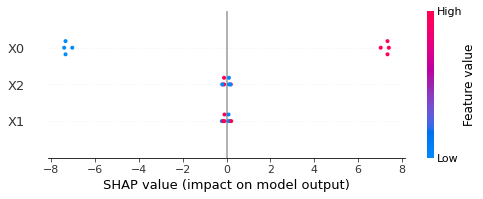

In [175]:
shap_net_x(LambdaNet(lambda x: ebm_ind.net_c[0](x)), shap_x, bs, column_name="logit Z")

It's very hard to tell whether the concept detector is overloaded as it is clearly more dependent on the first concept.

In fact we can even analytically define the concept vector as $[1, -0.1, -0.1]$. This clearly would prefer concept 0 in order to activate. However, it still gives away information about both concept 1 and concept 2.

### TODO: run this example with Yeh et al's measure

## TODO: EBM sequential

EBM sequential don't need concept dataset and the classification task to overlap, which is way more flexible. The lesson is we should not jointly train interpretable models: this would transfer to CCM.

## CCM residue: TODO refactor

It would fail because we know the impact should be the same for $Z_0$ and $Z_1$ and $Z_2$, but we would have observed $Z_0$ have less impact.

number of concepts to learn: 1
true number of concepts: 3
epoch   4: loss 3.198e-08


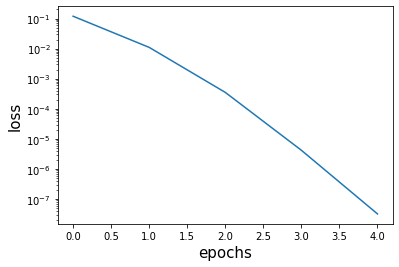

In [26]:
def res_CCM(ebm, d, c, X, Y, n_epochs=10, report_every=1, bs=100, plot=True):
    '''residue CCM: ebm is expert bottleneck model'''
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')
        
    # additional channel to fit residue
    # classification problem: pure residue does not work b/c y is not continous (cannot test acc)
    # we need to fit to the logit
    net_res = MLP([d, d * 2, 2])
    ebm.eval()
    dfs_freeze(ebm) # freeze parameter should be faster?
    net = AdditionNet(ebm, net_res)

    # train
    opt = optim.Adam(net_res.parameters())
    log = train(net, 
                DataLoader(TensorDataset(X, Y)), 
                opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net
    
ccm_res = res_CCM(copy.deepcopy(ebm_ind), d, c, X, Y, n_epochs=5, report_every=1) #n_epochs//10)

In [28]:
print('task acc after training: {:.2f}%'.format(test(ccm_res, loader_xy_te, acc_criterion ) * 100))

task acc after training: 100.00%


   X0  X1  X2  hat Y0  hat Y1
7   1   1   1     0.0     1.0
0   0   0   0     1.0     0.0
1   0   0   1     1.0     0.0
2   0   1   0     1.0     0.0
3   0   1   1     1.0     0.0
4   1   0   0     1.0     0.0
5   1   0   1     1.0     0.0
6   1   1   0     1.0     0.0
Explaining hat Y0


  0%|          | 0/8 [00:00<?, ?it/s]

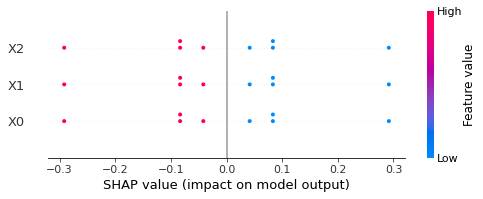

Explaining hat Y1


  0%|          | 0/8 [00:00<?, ?it/s]

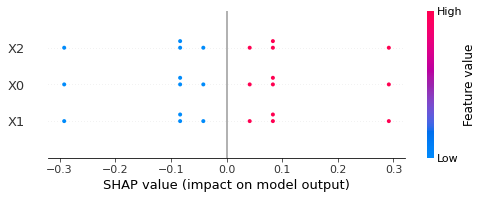

In [176]:
shap_net_x(nn.Sequential(ccm_res, nn.Softmax(dim=1)), shap_x, bs, column_name="hat Y")

They seem very symmetrical in the input space. However, if we focus on concept attribution:

In [ ]:
def shap_net_xc(concept_net, net, shap_x, bs, shap_idx=None, concept_name='Z', output_name='hat Y'):
    '''
    explain net at [input, concept] level
    '''
    explain_X = torch.from_numpy(np.array(shap_x))
    z_hat = get_output(concept_net,
                       DataLoader(TensorDataset(explain_X), batch_size=bs, shuffle=False))
    z_hat = pd.DataFrame(z_hat, columns=[f'{concept_name}{i}' for i in range(c)])
    shap_concepts = pd.concat((shap_x, z_hat), 1)
    
    # todo: rewrite ccm_res_net in x->c, [x, c]->hat y form, this will make this function so much easier to read
    ccm_res_concept = lambda x: F.softmax(ccm_res.net_a.net_y(torch.from_numpy(x[:, -c:])) + ccm_res.net_b(torch.from_numpy(x[:, :d])), 1).detach()[:, 1].numpy()

    # print prediction
    prediction = get_output(nn.Sequential(ccm_res, nn.Softmax(dim=1)),
                            DataLoader(TensorDataset(explain_X), batch_size=bs, shuffle=False))
    print(pd.concat((shap_concepts.round(2),
                     pd.DataFrame({f"{output_name}1": np.around(prediction[:, 1], 2)})), 1).sort_values(f'{output_name}1'))

    # shap explanation
    explainer = shap.KernelExplainer(ccm_res_concept, 
                                     shap_concepts)
    shap_values = explainer.shap_values(shap_concepts, nsamples=100)
    if shap_idx:
        shap.summary_plot(shap_values[shap_idx:shap_idx+1], shap_concepts)
    else:
        shap.summary_plot(shap_values, shap_concepts)

    X0   X1   X2   Z0  hat Y1
0  0.0  0.0  0.0  0.0     0.0
1  0.0  0.0  1.0  0.0     0.0
2  0.0  1.0  0.0  0.0     0.0
3  0.0  1.0  1.0  0.0     0.0
4  1.0  0.0  0.0  1.0     0.0
5  1.0  0.0  1.0  1.0     0.0
6  1.0  1.0  0.0  1.0     0.0
7  1.0  1.0  1.0  1.0     1.0


  0%|          | 0/8 [00:00<?, ?it/s]

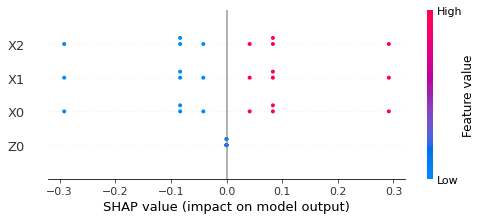

In [172]:
# todo: make this consistent with shap_net
def shap_ccm_res(ccm_res, shap_x, bs, c, shap_idx=None):
    '''if ccm is paired with joint ebm, Z0 is logit, else it is after sigmoid'''
    explain_X = torch.from_numpy(np.array(shap_x))
    z_hat = get_output(ccm_res.net_a.net_c,
                       DataLoader(TensorDataset(explain_X), batch_size=bs, shuffle=False))
    z_hat = pd.DataFrame(z_hat, columns=[f'Z{i}' for i in range(c)])
    shap_concepts = pd.concat((shap_x, z_hat), 1)

    ccm_res_concept = lambda x: F.softmax(ccm_res.net_a.net_y(torch.from_numpy(x[:, -c:])) + ccm_res.net_b(torch.from_numpy(x[:, :d])), 1).detach()[:, 1].numpy()

    # print prediction
    prediction = get_output(nn.Sequential(ccm_res, nn.Softmax(dim=1)),
                            DataLoader(TensorDataset(explain_X), batch_size=bs, shuffle=False))
    print(pd.concat((shap_concepts.round(2),
                     pd.DataFrame({"hat Y1": np.around(prediction[:, 1], 2)})), 1).sort_values('hat Y1'))

    # shap explanation
    explainer = shap.KernelExplainer(ccm_res_concept, 
                                     shap_concepts)
    shap_values = explainer.shap_values(shap_concepts, nsamples=100)
    if shap_idx:
        shap.summary_plot(shap_values[shap_idx:shap_idx+1], shap_concepts)
    else:
        shap.summary_plot(shap_values, shap_concepts)
    
shap_ccm_res(ccm_res, shap_x, bs, c)

**The concept appears to have no influence at all: the model recompute concepts from scratch**

number of concepts to learn: 1
true number of concepts: 3
    X0   X1   X2     Z0  hat Y1
0  0.0  0.0  0.0  -4.52    0.00
1  0.0  0.0  1.0  -6.43    0.00
2  0.0  1.0  0.0  -7.76    0.00
3  0.0  1.0  1.0  -9.67    0.00
4  1.0  0.0  0.0  13.65    0.00
5  1.0  0.0  1.0   8.67    0.00
6  1.0  1.0  0.0   8.71    0.00
7  1.0  1.0  1.0   3.73    0.96


  0%|          | 0/8 [00:00<?, ?it/s]

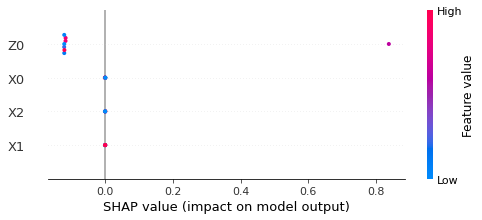

In [173]:
ccm_res_joint = res_CCM(copy.deepcopy(ebm_joint), d, c, X, Y, n_epochs=0, report_every=1, plot=False) #n_epochs//10)
shap_ccm_res(ccm_res_joint, shap_x, bs, c)

The above graph sanity checks that joint EBM based residue CCM does not use raw input